In [1]:
from os import path, makedirs, walk,listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, split_dataset
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from keras.callbacks import EarlyStopping
from keras.regularizers import L2
from random import choice

In [2]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
AUGMENTED_DATASET_DIRECTORY ='augmented_images'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')
TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS = path.join(AUGMENTED_DATASET_DIRECTORY ,'categorised_images')
AUGMENTATION_LAYERS = [RandomFlip("horizontal"), RandomRotation(0.2), RandomZoom(0.2), RandomContrast(0.2)]

#Hyperparameters
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), F1Score(name='f1'), TrueNegatives(name='tn'), TruePositives(name='tp'), FalseNegatives(name='fn'), FalsePositives(name='fp')]
EPOCHS = 50
BATCH_SIZE = 10
VERBOSE = 1
REGULARIZER=None
REGULARIZATION_FACTOR = 0.01
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (256,256,1)

2024-03-25 18:20:39.015865: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-25 18:20:39.015888: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-25 18:20:39.015896: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-25 18:20:39.016167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 18:20:39.016182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [ ]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

In [3]:
#remove any non-jpg files in the directories
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [4]:
#remove any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        for top_directory in (TOP_DIRECTORY_CLASSIFIFICATIONS, TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS):
            folder_path = path.join(top_directory, dataset_name,class_dir_name)
            print('checking folder: '+folder_path)
            find_and_remove_non_jpg_files(folder_path)
            folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: dataset/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categor

In [8]:
def load_images(a_dataset_directory):
        
    return image_dataset_from_directory(
        directory=a_dataset_directory,
        labels='inferred',
        label_mode="binary",
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        image_size=(256, 256),
        shuffle=False,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation="bilinear",
        follow_links=False
    )  

In [9]:
#Load the images into datasets
#load the datasets
train_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'train')
valid_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'valid')
test_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'test')
train_ds = load_images(train_ds_directory)
valid_ds= load_images(valid_ds_directory)
test_ds= load_images(test_ds_directory)
augmented_train_ds_directory = path.join(TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS, 'train')
augmented_valid_ds_directory = path.join(TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS, 'valid')
augmented_test_ds_directory = path.join(TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS, 'test')
augmented_train_ds = load_images(augmented_train_ds_directory)
augmented_valid_ds= load_images(augmented_valid_ds_directory)
augmented_test_ds= load_images(augmented_test_ds_directory)


#create a combined dataset so the data can be shuffled and then split into training and test sets
combined_ds = train_ds.concatenate(valid_ds).concatenate(test_ds)
print('combined_ds', combined_ds.cardinality())


Found 3630 files belonging to 2 classes.
Found 168 files belonging to 2 classes.
Found 347 files belonging to 2 classes.
train_ds tf.Tensor(363, shape=(), dtype=int64)
test_ds tf.Tensor(17, shape=(), dtype=int64)
valid_ds tf.Tensor(35, shape=(), dtype=int64)
combined_ds tf.Tensor(415, shape=(), dtype=int64)


In [10]:
combined_images = []
combined_labels = []
for images, labels in combined_ds.as_numpy_iterator():
    combined_images.extend(images)
    combined_labels.extend(labels)
combined_images = np.array(combined_images)
combined_labels = np.array(combined_labels)

X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

2024-03-25 06:45:10.597655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train (3316, 256, 256, 1)
X_test (829, 256, 256, 1)
y_train (3316, 1)
y_test (829, 1)


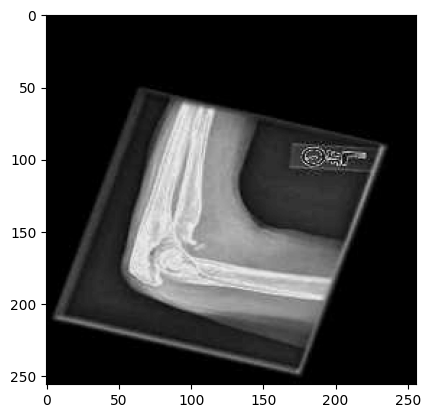

In [11]:
random_training_image = choice(X_train)
plt.imshow(random_training_image, cmap='gray')
plt.show()


    for layer in AUGMENTATION_LAYERS:
        image = layer(image)
    return image

In [12]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #Flatten the output so that it can be processed as a Vector by the subsequent Dense layer
    model.add(Flatten())
    #if using a regularizer, instantiate it with the regularization factor
    if REGULARIZER is not None:
        the_regularizer = REGULARIZER(REGULARIZATION_FACTOR)
    else:
        the_regularizer = REGULARIZER
    #add a fully connected layer with  256 neurons and a relu activation function outut shape = 64
    model.add(Dense(256, kernel_regularizer=the_regularizer, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [13]:
model = create_model(INPUT_SHAPE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,352,577 (226.41 MB)

 Trainable params: 59,352,577 (226.41 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def train_model(X_train, y_train):
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=VERBOSE, restore_best_weights=True)]
    
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(LEARNING_RATE), loss=LOSS_FUNCTION(), metrics=METRICS)
    model_history = model.fit(
                            X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            verbose=VERBOSE,
                            callbacks=callbacks)
    clear_session()

    return (model, model_history)

In [15]:
model, model_history = train_model(X_train, y_train)

Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 242s 904ms/step - accuracy: 0.5438 - f1: 0.6424 - fn: 315.1386 - fp: 295.2434 - loss: 0.6901 - precision: 0.5072 - recall: 0.4438 - tn: 389.4794 - tp: 340.0412 - val_accuracy: 0.6205 - val_f1: 0.6877 - val_fn: 0.0000e+00 - val_fp: 252.0000 - val_loss: 0.6454 - val_precision: 0.5800 - val_recall: 1.0000 - val_tn: 64.0000 - val_tp: 348.0000
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 245s 922ms/step - accuracy: 0.6743 - f1: 0.6568 - fn: 162.5655 - fp: 257.2846 - loss: 0.5886 - precision: 0.6441 - recall: 0.7565 - tn: 418.6629 - tp: 501.3895 - val_accuracy: 0.7726 - val_f1: 0.6877 - val_fn: 34.0000 - val_fp: 117.0000 - val_loss: 0.4961 - val_precision: 0.7285 - val_recall: 0.9023 - val_tn: 199.0000 - val_tp: 314.0000
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 216s 811ms/step - accuracy: 0.7978 - f1: 0.6627 - fn: 78.8502 - fp: 190.8015 - loss: 0.4367 - precision: 0.7504 - recall: 0.8871 - tn: 487.2959 - tp: 582.9551 - val_accuracy: 0.7711 - val_f1: 0.6884 -

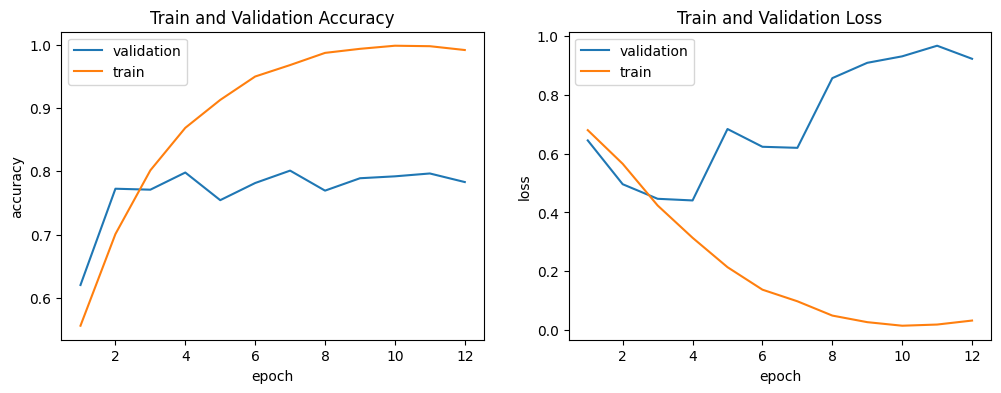

In [16]:
#plot the model accuracy and loss
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [17]:
results  = model.evaluate(X_test, y_test)
print('accuracy', results[1])
print('loss', results[0])
print('precision', results[2])
print('recall', results[3])
print('f1', results[4])
print('tn', results[5])
print('tp', results[6])
print('fn', results[7])
print('fp', results[8])

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step - accuracy: 0.8241 - f1: 0.7084 - fn: 39.0370 - fp: 41.9259 - loss: 0.5242 - precision: 0.8278 - recall: 0.8299 - tn: 177.0370 - tp: 188.5926
accuracy 0.8082026243209839
loss 0.5386360883712769
precision 0.7013422250747681
recall 76.0
f1 83.0
tn 0.8047058582305908
tp 0.8181818127632141
fn 328.0
fp 342.0


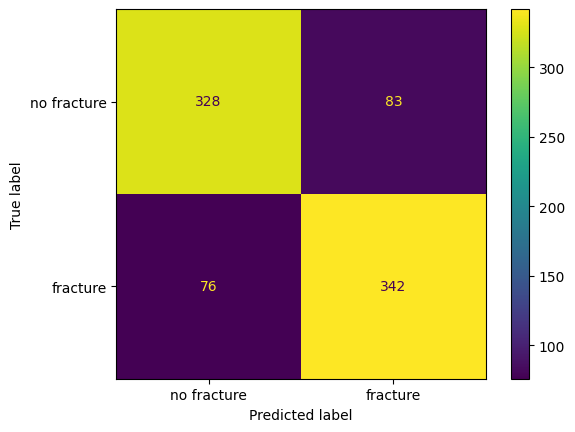

In [26]:
predictions = model.predict(X_test)
binary_predictions = np.where(predictions > 0.5, 1, 0)
binary_predictions
matrix = confusion_matrix(y_test, binary_predictions)
ConfusionMatrixDisplay(matrix, display_labels=['no fracture', 'fracture']).plot()

In [27]:
import datetime
print("Last modified: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")

Last modified:  25/03/2024 09:15:27
